# Классификация изображений с эмоциями людей

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tqdm import tqdm

print("TensorFlow Version:", tf.__version__)
print('GPU Device Found.' if tf.config.list_physical_devices('GPU') else 'GPU Device Not Found. Running on CPU')

TensorFlow Version: 2.11.0
GPU Device Found.


# <b>ВВЕДЕНИЕ</b>

Модели для данной работы были разработаны инструментами библиотек PyTorch, TensorFlow, Scikit-learn. После ряда экспериментов были отобраны по две модели на каждый фреймворк.

Используемый датасет собран нами вручную под конкретную задачу из имеющейся в нашем распоряжении базы данных изображений (около 140 тысяч изображений).

Конечный документ обучен с ипользованием GPU, предоставляемых платформой "Kaggle".

# <b>1. ПОДГОТОВИТЕЛЬНЫЙ ЭТАП</b>

## 1.1. Подготовка файлов для работы с локального диска

### Загрузка данных на локальный диск

Данную ячейку по очистке рабочей директории  запускать **ТОЛЬКО** в ноутбуках Kaggle перед началом обучения на GPU.

In [2]:
# # DO NOT RUN ON YOUR LOCAL MACHINE!!!

# import os
# dir_to_delete = '/kaggle/working/'
# with os.scandir(dir_to_delete) as entries:
#     for entry in entries:
#         file_to_delete = f"{dir_to_delete}{entry.name}"
#         if os.path.isfile(file_to_delete):
#             print(file_to_delete)
#             os.remove(file_to_delete)

# # Clear output folder
# import os

# def remove_folder_contents(folder):
#     for the_file in os.listdir(folder):
#         file_path = os.path.join(folder, the_file)
#         try:
#             if os.path.isfile(file_path):
#                 os.unlink(file_path)
#             elif os.path.isdir(file_path):
#                 remove_folder_contents(file_path)
#                 os.rmdir(file_path)
#         except Exception as e:
#             print(e)

# folder_path = '/kaggle/working'
# remove_folder_contents(folder_path)
# os.rmdir(folder_path)

In [3]:
# # активировать при обучении в Kaggle
!pip install gdown

In [4]:
import gdown
import zipfile
from pathlib import Path

# Загрузка архива
# stable link https://drive.google.com/file/d/1JdDlgpvtlMN99X0eAruGqXrMNi_sh1sg
ident = '1JdDlgpvtlMN99X0eAruGqXrMNi_sh1sg'
fname = 'emotions'

# Пусть к основной папке с изображениями
p = Path('./data')

# Путь к базовой директории, которая будет создана чуть позже
base_dir = p / fname

local_zip = gdown.download(id=ident, output=fname+'.zip')

Downloading...
From: https://drive.google.com/uc?id=1JdDlgpvtlMN99X0eAruGqXrMNi_sh1sg
To: /kaggle/working/emotions.zip
100%|██████████| 14.8M/14.8M [00:00<00:00, 86.9MB/s]


Распаковка в текущую директорию.

In [5]:
with zipfile.ZipFile(local_zip, 'r') as zip_ref:
    zip_ref.extractall(p)

Теперь загруженный архив можно удалить.

In [6]:
import os

os.remove(fname + '.zip')

Переименуем папку с изображениями в `emotions`. Для отключения ограничения "Только чтение" у папки с изображениями воспользуемся следующей функцией ([источник](https://www.tutorialspoint.com/How-to-change-the-permission-of-a-directory-using-Python#)):

In [7]:
def change_permissions_recursive(path, mode):
    for root, dirs, files in os.walk(path, topdown=False):
        for dr in [os.path.join(root,d) for d in dirs]:
            os.chmod(dr, mode)
        for file in [os.path.join(root, f) for f in files]:
                os.chmod(file, mode)

In [8]:
zip_content = os.listdir(p)[0]
zip_content

'emotions_dataset'

Функция не всегда срабатывает с первого раза, поэтому запустим следующий цикл:

In [9]:
done = False

while done == False:
    try:
        change_permissions_recursive(p, 0o777)
        change_permissions_recursive(p / zip_content, 0o777)
        zip_content = os.renames(p / zip_content,
                   base_dir)
        done = True
    except:
        continue

### Настройка директорий

Проверим содержимое папки с изображениями, мы должны увидеть список из папок с названиями этих папок и их количество. 

In [10]:
from pathlib import Path

# Базовая директория
classes = sorted(os.listdir(base_dir))

num_classes = len(classes)

# и ее содержимое
print("Содержимое базовой директории:")
print(classes)
print('Количество классов:', num_classes)

Содержимое базовой директории:
['ANGER', 'DISGUST', 'FEAR', 'JOYFULNESS', 'NEUTRAL']
Количество классов: 5


Переименуем папки в необходимые нам названия классов:

In [11]:
# class_names = [x.lower() for x in classes]
class_names = sorted(['anger', 'disgust', 'fear', 'joyfulness', 'neutral'])

done = False
while done == False:
    try:
        change_permissions_recursive(base_dir, 0o777)
        done = True
    except:
        continue

done = False
while done == False:
    try:
        for i, class_name in enumerate(sorted(class_names)):
            change_permissions_recursive(base_dir/class_name, 0o777)
            os.renames(base_dir/classes[i], base_dir/class_name)
        done = True
    except:
        continue

classes = sorted(os.listdir(base_dir))

In [12]:
classes

['anger', 'disgust', 'fear', 'joyfulness', 'neutral']

### Удалим некорректные файлы

Если в архиве содержатся некорректные ("битые") файлы, то мы получим ошибку на том или ином этапе обучения и подготовки модели к переносу на мобильное устройство. Код ниже позволяет обнаружить и сразу удалить такие файлы при их наличии. Запустим эту функцию для всех папок с классами ([источник кода](https://github.com/tensorflow/datasets/issues/2188)).

In [13]:
from pathlib import Path
from tensorflow.io import read_file
from tensorflow.image import decode_image

def delete_corrupted_files(folder, base_dir):
    for image in sorted((base_dir / f'{folder}').glob('*')):
        try:
            img = read_file(str(image))
            img = decode_image(img)

            if img.ndim != 3:
                print(f"[FILE_CORRUPT] {str(image).split('/')[-1]} DELETED")
                image.unlink()

        except Exception as e:
            print(f"[ERR] {str(image).split('/')[-1]}: {e} DELETED")
            image.unlink()

In [14]:
for folder in classes:
    print(folder)
    delete_corrupted_files(folder, base_dir)

anger
disgust
[ERR] 5a971597aae6052a008b45a7.webp: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] DELETED
[ERR] Universal_Expression_Disgust.webp: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] DELETED
[ERR] gettyimages-520925691.webp: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] DELETED
fear
joyfulness
neutral


Битых файлов нет, можно двигаться дальше.

Сохраним пути к субдиректориям с классами в отдельные переменные и посмотрим на конечное количество изображений в каждом классе.

In [15]:
anger_dir, disgust_dir, fear_dir, joyfulness_dir, neutral_dir = [base_dir / classes[i]
                                                   for i in range(len(classes))]
directories = anger_dir, disgust_dir, fear_dir, joyfulness_dir, neutral_dir


anger_fnames, disgust_fnames, fear_fnames, joyfulness_fnames, neutral_fnames = [os.listdir(i)
                                                              for i in directories]
files_names = anger_fnames, disgust_fnames, fear_fnames, joyfulness_fnames, neutral_fnames


for i, cls_name in enumerate(class_names):
    print(cls_name + ':', len(files_names[i]))

anger: 174
disgust: 292
fear: 177
joyfulness: 339
neutral: 398


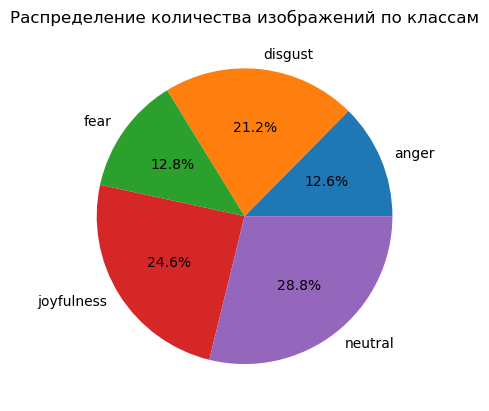

In [16]:
import seaborn as sns

x = np.array([len(anger_fnames), len(disgust_fnames),
              len(fear_fnames), len(joyfulness_fnames),
              len(neutral_fnames)])

plt.title('Распределение количества изображений по классам')
plt.pie(x, labels=classes, autopct='%.1f%%');

Классы несбалансированы, поэтому, помимо метрики `accuracy`, для оценки ошибки классификации мы будем использовать метрики, основанные на `precision` и `recall`, а также матрицу ошибок.

In [17]:
print(len(class_names))

5


Посмотрим на названия отдельных файлов.

In [18]:
for i, j in zip(class_names, files_names):
    print(i, j[90:93])

anger ['77144.jpg', '96163.jpg', '82388.jpg']
disgust ['58139.jpg', '172104.jpg', '90895.jpg']
fear ['5970.jpg', '221981.jpg', '1891.jpg']
joyfulness ['4259.jpg', '1093.jpg', '1028.jpg']
neutral ['28111.jpg', '15494.jpg', '171255.jpg']


### Визуализация оригинальных изображений

Посмотрим на фотографии из обеих субдиректорий - по 4 фотографии каждого класса.

In [19]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Параметры для отрисовки - количество строк и столбцов
nrows = 5
ncols = 4

# Индекс для итерации изображений
pic_index = 0

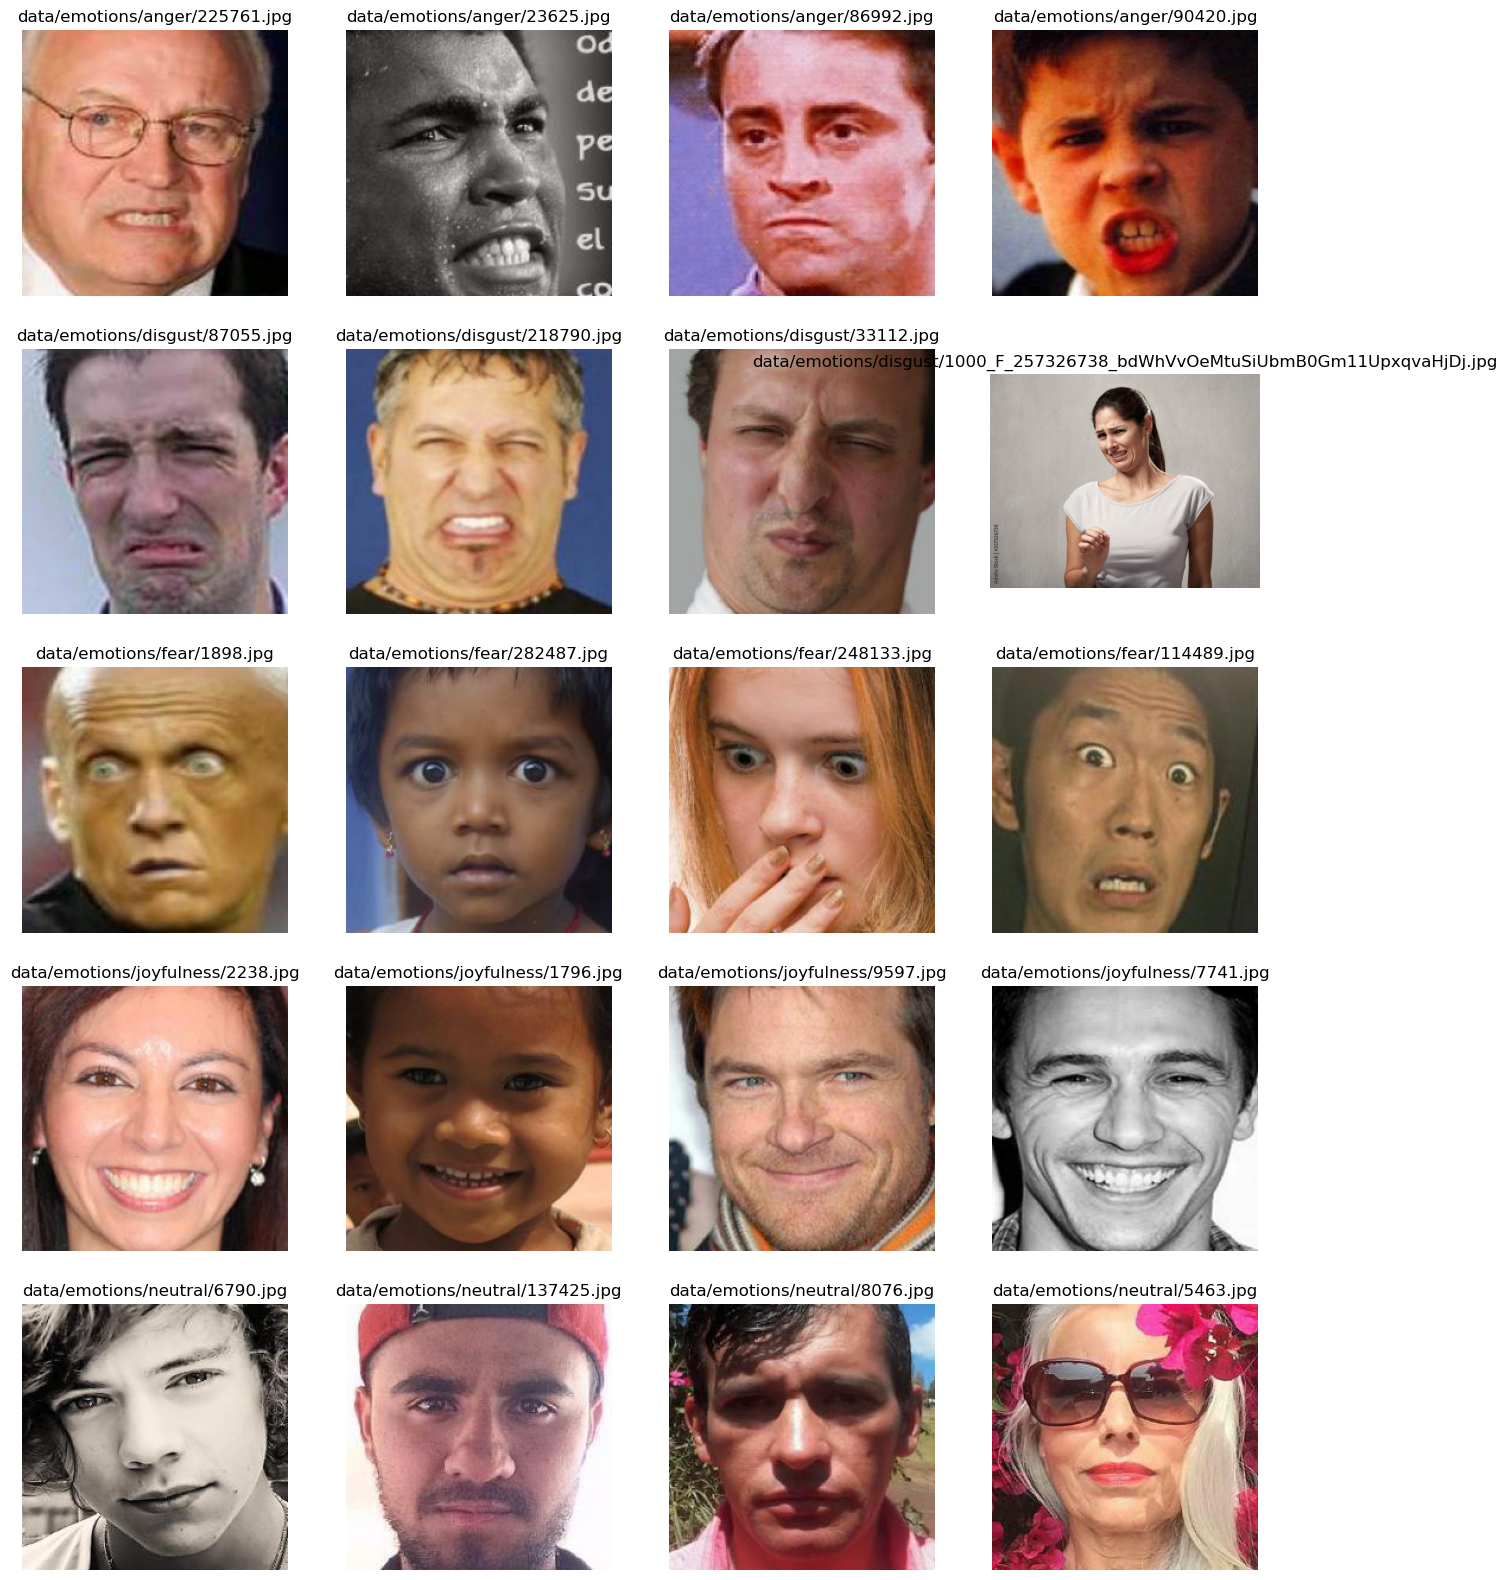

In [20]:
# Запустите эту ячейку несколько раз, чтобы увидеть разные наборы фотографий

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index += 4

next_anger_pic = [os.path.join(anger_dir, fname)
                for fname in anger_fnames[pic_index-4:pic_index]]
next_disgust_pic = [os.path.join(disgust_dir, fname)
                for fname in disgust_fnames[pic_index-4:pic_index]]
next_fear_pic = [os.path.join(fear_dir, fname)
                for fname in fear_fnames[pic_index-4:pic_index]]
next_joyfulness_pic = [os.path.join(joyfulness_dir, fname)
                for fname in joyfulness_fnames[pic_index-4:pic_index]]
next_neutral_pic = [os.path.join(neutral_dir, fname)
                for fname in neutral_fnames[pic_index-4:pic_index]]


for i, img_path in enumerate(next_anger_pic+next_disgust_pic+
                            next_fear_pic+next_joyfulness_pic+
                            next_neutral_pic):
    ax = plt.subplot(nrows, ncols, i+1)
    ax.axis(False)
    plt.title(img_path)
    
    img = mpimg.imread(img_path)
    plt.imshow(img)


Изображения в имеющихся наборах имеют различное разрешение и соотношение сторон, их необходимо привести к единому стандарту на стадии формирования датасетов для наших моделей. Этим мы сейчас и займемся.

### Создание DataFrame для "случайного леса"

Для "случайного леса" изображения необходимо перевести в векторы, объединить эти векторы в одну DataFrame, добавив последним столбцом номера классов (от 0 до 4, ординальная кодировка). Следующий код аккуратно проделает все операции, на выходе мы получаем желаемую DataFrame, после чего ее можно будет разделить средствами библиотеки sklearn на обучающую и валидационную части.

In [21]:
import pandas as pd
from PIL import Image

# создадим пустые списки для векторов по классам
anger_features = []
disgust_features = []
fear_features = []
joyfulness_features = []
neutral_features = []
features_lst= sorted([anger_features, disgust_features,
                      fear_features, joyfulness_features,
                      neutral_features])

# переведем изображения в вектора, добавим таргет
# и сохраним в списках
final_df = pd.DataFrame()  # пустой датафрейм
for name, lst in zip(class_names, features_lst):
    fpath = base_dir / name
    lst_idx = features_lst.index(lst)
    for img in os.listdir(fpath):

        img = Image.open(fpath/img)
        img = np.array(img)

        if img.shape == (224, 224, 3):

            a = np.reshape(img, (224*224*3))
            b = np.ones(1, dtype='uint8')*lst_idx
            c = np.append(a, b)
            lst.append(c)

    # добавим все данные в общую таблицу
    final_df = pd.concat([final_df, pd.DataFrame(lst)], axis=0)

final_df.index = range(final_df.shape[0])

In [22]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Columns: 150529 entries, 0 to 150528
dtypes: int8(150529)
memory usage: 197.0 MB


In [23]:
final_df.shape

(1372, 150529)

### Split изображений для нейросетей

Так как для оценки работы нейросетей мы создаем отдельный датасет с тестовыми изображениями и в одном из используемых фреймворков (tensorflow) готовых инструментов для формирования датасета из трех частей (тренировка, валидация, тест) нет, предварительно необходимо разделить все изображения на соответствующие директории, внутри которых будут папки с классами. После этого создать датасеты для torch и tf будет несложно.

Напишем собственную функцию, которая переместит все изображения по нужным нам папкам, создав, таким образом, необходимое разделение данных на три датасета. Функция содержит вложенную функцию `split_numbers`, которая автоматически определит количество изображений, необходимое для каждого сплита по всем классам в соотношении: `train : validation : test = 8:1:1` (значение по умолчанию). Однако при необходимости это соотношение можно изменить в любую сторону, для этого нужно указать значения для тренировочной и валидационной частей, тестовая часть посчитается автоматически как остаток (при этом нужно помнить, что сумма частей, на которые мы делим датасает, должна быть кратна 10; при желании это правило можно изменить, переписав вложенную функцию).

In [24]:
from pathlib import Path
import shutil
import os

def make_split(files_names, base_dir, class_folder, relation=(8, 1)):

    dataset_split_folders = 'train', 'validation', 'test'
    train_dir, val_dir, test_dir = [base_dir / i
                    for i in dataset_split_folders]

    for directory in (train_dir, val_dir, test_dir):
        try:
            Path.mkdir(directory)
        except:
            # print(f'Directory {directory} already exists or cannot be created.')
            pass
        try:
            Path.mkdir(directory / class_folder)
        except:
            # print(f'Directory {directory / class_folder} already exists or cannot be created.')
            pass

    def split_numbers(files_names=files_names):
        imgs_num = len(files_names)
        train_num, val_num = int(imgs_num//10*relation[0]), int(imgs_num//10*relation[1])
        test_num = imgs_num - train_num - val_num
        return train_num, val_num, test_num

    examples = split_numbers(files_names)
    directories = train_dir, val_dir, test_dir

    for num, dr in zip(examples, directories):
        i = num
        while i != 0:
            image_name = os.listdir(base_dir / class_folder)[i-1]
            shutil.move(base_dir / class_folder / image_name,
                         dr / class_folder / image_name)
            i -= 1

    shutil.rmtree(base_dir / class_folder)

Применим эту функцию к каждому из классов.

In [25]:
for i in range(len(classes)):
    make_split(files_names[i],
             base_dir=base_dir,
             class_folder=sorted(classes)[i],
             # изменим немного соотношение в пользу валидации
             relation=(8, 1.2))

Наш датасет разделен на три части в соотношении примерно 8 : 1.2 : 0.8. Теперь у нас имеются три директории, содержащие папки с нужными нам классами.

In [26]:
for i in os.listdir(base_dir):
    print(i, os.listdir(base_dir / i))

train ['neutral', 'disgust', 'anger', 'joyfulness', 'fear']
test ['neutral', 'disgust', 'anger', 'joyfulness', 'fear']
validation ['neutral', 'disgust', 'anger', 'joyfulness', 'fear']


# 1.2. Подготовка функций и переменных для обучения | <b>PyTorch</b>

# 1.3. Подготовка функций и переменных для обучения | <b>TensorFlow</b>

## Архитектура, компиляция, обучение модели

`DROPOUT_RATE` назначим небольшим, так как датасет у нас скромный по объему и, если мы будем исключать значительную часть датасета из обучения, модель просто не сможет обучаться.

Также назначим переменную базовый learning rate - `BASE_LR`, установим значение на 0.01. Мы будем использовать специальный инструмент `callbacks`, который при необходимости будет уменьшать данный параметр непосредственно в ходе обучения.

In [27]:
DROPOUT_RATE = 0.2
BASE_LR = 0.01
REGULARIZER=tf.keras.regularizers.L1L2(l1=0.0, l2=0.5)
EPOCHS=500  # см. callbacks

В качестве метрик будем использовать традиционную `accuracy` (в дань уважения традиции, для оценки работы классификатора на несбаланированных данных эта метрика не имеет большого смысла, так как она считает среднее по ошибкам, не учитывая крайности) и `PR-AUC` - площадь под графиком метрик precision и recall, которая позволяет учесть данные по редким классам и получить более объективную картину об эффективности обучения в нашем случае. Также можно было использовать метрику F1 Score, но готовый класс этой метрики на данный момент доступна только в "ночной" версии tf, а прописывать свой собственный класс мы не стали в связи с наличием готового инструмента PR-AUC, вполне удовлетворяющего нашим задачам.

In [28]:
curve = 'PR'
name = curve+'_AUC'
AUC = tf.keras.metrics.AUC(curve=curve, multi_label=False, name=name)

# список с метриками
metrics = ['accuracy', AUC]

### Callbacks - контроль остановки обучения и `learning_rate`

Так как обучение моделей по компьютерному зрению очень затратно по ресурсам, а мы проводили целый ряд различных экспериментов, для снижения нагрузки на систему мы использовали так называемые `callbacks` - специальные модули `keras`, которые позволяют в автомтическом режиме контролировать, когда следует вносить те или иные изменения в обучение и даже останавливать его. Мы будем использовать два вида `callbacks`:

- `EarlyStopping` для ранней остановки обучения при прекращении уменьшения `val_loss` (для нашего несбалансированного датасета этот показатель важнее, чем непоказательный для несбалансированных классов `val_accuracy`),

- `ReduceLROnPlateau` для уменьшения `learning rate` при ухудшении показателей `val_loss` (постепенное снижение `learning rate` в процессе обучения положительно сказывается на качестве обучения, что мы увидели на наших экспериментах).

In [29]:
from tensorflow.keras import callbacks

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=1e-4,  # минимальное значение для зачета улучшения
    patience=12,  # количество эпох с плохим результатом перед остановкой
    restore_best_weights=True,  # восстановить лучшие показатели модели
)

# early_stopping = callbacks.EarlyStopping(
#     monitor='val_PR_AUC',
#     min_delta=1e-4,  # минимальное значение для зачета улучшения
#     patience=12,  # количество эпох с плохим результатом перед остановкой
#     restore_best_weights=True,  # восстановить лучшие показатели модели
#     mode="max"
# )

lr_schedule = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=1,
    factor=0.85,  # на какое значение будет умножаться текущий lr
    min_lr=1e-8  # минимальное значение lr
)

Таким образом, наши callbacks создают следующий алгоритм: 
- при ухудшении `val_loss` на данной эпохе следующая эпоха будет прходить с `learning rate` на 15% ниже,
- если `val_loss` не улучшается 12 раз кряду, обучение прекращается.

Все эти параметры можно регулировать и подбирать, для наших задач мы остановимся на этих гиперпараметрах, так как в ходе экспериментов они показали себя достаточно эффективными.

## Визуализация итогов обучения

Также пропишем функции для отрисовки результатов обучения - графики функции потерь и метрик (обучающая и валидационная выборка), а также матрицу ошибок (тестовая выборка).

### Функция потерь и метрики

In [30]:
def val_acc_viz(history, epochs, loss_from=1):
    '''
    Функция отрисовывает историю функции потерь и
    используемых метрик. Аргументы:
    - history - данные истории обучения,
    - epochs - количество эпох для отображения,
    - loss_from - с какой эпохи отображать loss.
    '''
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    auc = history.history[name]
    val_auc = history.history['val_' + name]

    loss = history.history['loss'][loss_from-1:]
    val_loss = history.history['val_loss'][loss_from-1:]

    epochs_range = range(1, len(acc)+1)

    sns.set_style('whitegrid')
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 3, 1)
    plt.plot(range(loss_from, len(acc)+1), loss, label='Training Loss')
    plt.plot(range(loss_from, len(acc)+1), val_loss, label='Validation Loss')
    plt.legend(loc='best')
    plt.title('Loss')
    plt.xlabel('epochs')
    # plt.show()

    # plt.figure(figsize=(8, 5))
    # ax1 = plt.subplot(1, 2, 1)
    ax2 = plt.subplot(1, 3, 2)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='best')
    plt.title('Accuracy')
    plt.xlabel('epochs')

    # plt.subplot(1, 2, 2, sharey=ax1)
    plt.subplot(1, 3, 3, sharey=ax2)
    plt.plot(epochs_range, auc, label='Training ' + name)
    plt.plot(epochs_range, val_auc, label='Validation ' + name)
    plt.legend(loc='best')
    plt.title(name)
    plt.xlabel('epochs')
    plt.show()

### Функция матрицы ошибок

В функции матрицы ошибок использованы инструменты библиотеки scikit-learn, что особенно удобно для отрисовки матрицы, хотя при желании можно прописать функцию отрисовки матрицы вручную.

In [31]:
def confusion_matrix(model, dataset, images_number=None, class_names=class_names):

    '''
    Выводит матрицу ошибок на тестовых данных. 
    
    Аргументы:
    - model - обученная модель.
    - dataset - tf.dataset с тестовыми изображениями.
    - images_number - int: количество изображений из тестовой выборки;
            если None, то используются все изображения в выборке (по
            условию).
    - class_names - list: названия классов.
    '''
    
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

    
    if images_number is None:
        test_images = dataset
    else:
        test_images = dataset.take(images_number)

    y_test = list()
    y_pred = list()
    for x, y in test_batches:
        y_test.append(np.argmax(y))
        y_pred.append(np.argmax(model.predict(x, verbose=0)))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='GnBu')
    # disp.plot(cmap='afmhot')

    plt.show()

## Предсказания на изображениях из тестовой выборки

Следующая функция покажет предсказания по заданному числу изображений из тестовой выборки (по условию 10), реальное и предсказанное значение класса, изображение при активации `visualization`), а также "уверенность" модели в своем предсказании. 

In [32]:
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array
import os

def show_predictions(model, dataset,
                     images_number=10, visualization=False):

    '''
    Функция предсказания по заданному числу изображений из тестовой
    выборки (по условию 10), реальное и предсказанное значение класса,
    изображение при активации `visualization`), а также
    "уверенность" модели в своем предсказании.
    
    Аргументы:
    -  model - обученная модель.
    - images_number - int: количество изображений, предсказания по которым
      мы хотим получить (по условию 10).
    - visualization - bool: отрисовка изображений (по условию False).
    
    '''
    
    images = dataset.take(images_number)

    for img, label in images:

        if visualization == True:
            plt.figure(figsize=(2, 2))
            # Отключить оси
            plt.axis(False)
            # оставим три измерения из четырех
            image = np.squeeze(img)
            plt.imshow(image.astype('uint8'))
            plt.show()

        # реальный класс
        label = np.argmax(label)
        # предсказанный класс
        prediction = model.predict(img, verbose=0)
        pred = np.argmax(prediction)

        print(f'{class_names[label]} is {class_names[pred]} ({np.max(prediction[0])*100:.2f}%)')

# <b>2. МОДЕЛИ</b>

# <b>2.1. PyTorch</b>

# <b>2.2. TensorFlow</b>

## <b>Предварительные замечания</b>

### О выбранной тактике обучения моделей

В данной работе представлены две модели, реализованные инструментами библиотеки TensorFlow. Обе модели обучены на предобученных моделях, которые используются для задачи классификации изображений - `InceptionV3` и `MobileNetV2` (обе обучены на базе данных ImageNet). Подробно о моделях можно прочитать в специальных статьях, ссылки на которые приведены ниже.

В библиотеке TensorFlow существует как минимум два способа использования предобученных моделей:

- с использованием библиотеки моделей `tensorflow-hub`,
- с использованием модуля Keras `tf.keras.applications`.

Первый способ проще в имплементации, однако у него есть существенный для разработчика недостаток - предобученные модели поставляются как единый слой и не подлежат частичной разморозке, разморозить можно только все слои зараз, отчего важным становится правильный выбор версии данной модели (то есть мы имеем дело с семействами моделей). Также два способа отличаются методом `rescale` - в первом случае изображения необходимо привести к стандарту [0, 1], тогда как во втором - [-1, 1]. Это необходимо иметь ввиду при подготовке наших изображений перед отправкой на обучение.

Мы используем второй способ, так как он гораздо более пластичен для тонкой настройки и позволяет экспериментировать с гиперпараметрами.

Всего для подотовки дипломного проекта было использовано четыре различных предобученных модели с использованием различных оптимизаторов (`SGD`, `RMSprop`, `Adam`) и функций потерь (`mse`, `categorical crossentropy`), лучшие параметры были определены в ходе ряда экспериментов. С большей частью экспериментов можно ознакомиться по [ссылке](https://github.com/lefthand67/SBER_Diploma/tree/main/experiments) (подробных словесных описаний на данный момент нет, но названия и подписи говорят сами за себя).

В данной работе представлены модели, построенные на связке `RMSprop/mse`, как показавшие себя с лучшей стороны. Также эксперименты показали, что данный датасет с данной связкой optimizer/loss повышает эффективность обучения при добавлении в слой классификации регуляризатора Ridge Regression (`L2`) со степенью 0.5 (эксперименты проведены на созданной с нуля нейросети, без предобученной модели). Для снижения вероятности переобучения добавлены слои аугментации и слой `dropout` (степень 0.2). 

Архитектура представленных в работе моделей отличается минимализмом - отсутствуют слои свертки и дополнительные полносвязные слои перед классификатором, так как на экспериментах данные опыты дали результат хуже базовых моделей ([эксперименты](https://github.com/lefthand67/SBER_Diploma/blob/main/experiments/01_tf_pretrained_InceptionResNetV2.ipynb) проводились на предобученной модели `InceptionResNetV2`).

Обучение представленных моделей происходило в два этапа: 
- сначала обучается классификатор на базе предобученной модели, у которой отключены верхние слои (include_top=False),
- затем мы размораживаем часть слоев предобученной модели и дообучаем наш классификатор.

Рассмотрим эти этапы подробнее.

### `feature_extractor` и `bottleneck layer`

На первом этапе создается `feature_extractor`, который извлекает веса из предобученной модели для переноса обучения на нашу модель. При переносе обучения рекомендуется отключать самые "верхние", то есть последние слои, вплоть до самого последнего перед слоем `Flatten` предобученной модели: именно в них происходит обучение на данную классификацию, в то время как мы собираемся строить свой классификатор. Самый последний слой перед `Flatten` содержит самые  общие признаки изображений (в литературе его называют слоем "бутылочное горлышко" - "bottleneck layer"), именно поэтому он представляет для нас наибольшую ценность. Данная задача решается отключением аргмуента `include_top` и добавлением слоя `Flatten` для перевода тензора изображений в векторный вид (или можно просто активировать аргумент `pooling` внутри самого `feature_extractor`). 

### Разморозка слоев

За "разморозку" слоев у нас будет отвечать параметр `do_fine_tuning`, который может принимать только булевы значения (в первых двух блоках он установлен в режим `False`). В официальных документах указано, что размораживать слои следует только после того, как мы уже обучили собственный классификатор c отключенным режимом `training`, в ином случае предобученная модель с установленными в случайном порядке весами для новых слоев при обновлении весов потеряет все, чему она была обучена. Кроме того, в общем случае нет необходимости в разморозке "нижних слоев", так как они обнаруживают самые простые и общие закономерности, характерные для любых изображений, тогда как цель применения предобученной модели - использовать более "специализированные" слои для дообучения новой модели на новом датасете (тем не менее в модели с использованием MobileNetV2 мы разморозим все слои ввиду минималистичности данной предобученной модели, специально разработанной для переносных устройств).

Особого внимания в случае разморозки `feature_extractor` заслуживают слои bacth normalization (`BN`). Это единственные встроенные слои, веса которых не должны обновляться при градиентном спуске, так как эти веса - движущиеся среднее значение и стандартное отклонение, используемые для нормализации текущего батча. Запустив модель в режиме `training=False`, мы эти слои заморозили. Когда мы на следующем шаге размораживаем всю модель или ее часть (`feature_extractor.trainable=True`), слои BN продолжают работать в режиме inference (движущиеся mean и std), а не обучения (mean и std текущего батча). Это очень важный момент, так как если мы запустим `feature_extractor` сразу в режиме разморозки без предварительного обучения на замороженных слоях (то есть не заморозим веса BN), слои BN будут давать непредсказуемый результат (подробнее о проблеме [здесь](https://keras.io/getting_started/faq/#whats-the-difference-between-the-training-argument-in-call-and-the-trainable-attribute)).

## <b>Подготовка данных для модели</b>

Подготовим все необходимые переменные для создания датасетов под данные модели. На данном этапе пропишем переменные для первой модели с использованием InceptionV3, чтобы проверить корректность работы всех инструментов. Для второй модели мы внесем изменения в свое время.

### Гиперпараметры для модели с переносом обучения

Пропишем гиперпараметры для модели, которые обеспечат нам правильную работу алгоритма.

In [33]:
MODULE_HANDLE = 'tf.keras.applications.InceptionV3'

pixels = 299  # разрешение изображений, используемое в InceptionV3

IMAGE_SIZE = (pixels, pixels)
IMG_SHAPE = IMAGE_SIZE + (3,)
BATCH_SIZE = 32

print(f"Используем {MODULE_HANDLE}, входное разрешение: {IMAGE_SIZE}, размер батча: {BATCH_SIZE}.")

Используем tf.keras.applications.InceptionV3, входное разрешение: (299, 299), размер батча: 32.


### Создание датасетов | `image_dataset_from_directory`

Для обучения модели предварительно разделенные по папкам изображения необходимо перевести в формат `dataset`. Для выполнения этой задачи будем использовать метод библиотеки `keras` `image_dataset_from_directory`. В качестве `label_mode` установим `categorical` для перевода лейблов в вид `one_hot_encoding`.

Весь необходимый код оформим в функцию, которая в одну строчку создаст три датасета под любую предобученную модель.

In [34]:
from pathlib import Path

def datasets_prep(base_directory=base_dir,
                  batch_size=BATCH_SIZE,
                  image_size=IMAGE_SIZE, 
                  label_mode='categorical',
                  seed=123):
    
    train_dir = base_dir / 'train'
    val_dir = base_dir / 'validation'
    test_dir = base_dir / 'test'
    
    train_ds = tf.keras.utils.image_dataset_from_directory(
                            train_dir,
                            label_mode=label_mode,
                            seed=seed,
                            image_size=IMAGE_SIZE,
                            batch_size=batch_size)
    
    val_ds = tf.keras.utils.image_dataset_from_directory(
                            val_dir,
                            label_mode=label_mode,
                            seed=seed,
                            image_size=IMAGE_SIZE,
                            batch_size=batch_size)
    
    test_ds = tf.keras.utils.image_dataset_from_directory(
                            test_dir,
                            label_mode=label_mode,
                            seed=seed,
                            image_size=IMAGE_SIZE,
                            batch_size=1)  # установим батч = 1
    
    return train_ds, val_ds, test_ds

In [35]:
train_batches, validation_batches, test_batches = datasets_prep()

Found 1080 files belonging to 5 classes.
Found 159 files belonging to 5 classes.
Found 141 files belonging to 5 classes.


Проверим созданные датасеты на соответствие заданным выше параметрам.

In [36]:
for ds in (train_batches, validation_batches, test_batches):
    for image_batch, label_batch in ds.take(1):
        print(image_batch.shape)

(32, 299, 299, 3)
(32, 299, 299, 3)
(1, 299, 299, 3)


Как и требовалось, тренировочный и валидационный датасеты содержат в батче установленное количество изображений, тестовый - 1.

Проверим классы, верно ли отработал данный инструмент.

In [37]:
for ds in (train_batches, validation_batches, test_batches):
    print(ds.class_names)

class_names = train_batches.class_names
num_classes = len(class_names)

['anger', 'disgust', 'fear', 'joyfulness', 'neutral']
['anger', 'disgust', 'fear', 'joyfulness', 'neutral']
['anger', 'disgust', 'fear', 'joyfulness', 'neutral']


### Визуализация изображений из `train_batches`

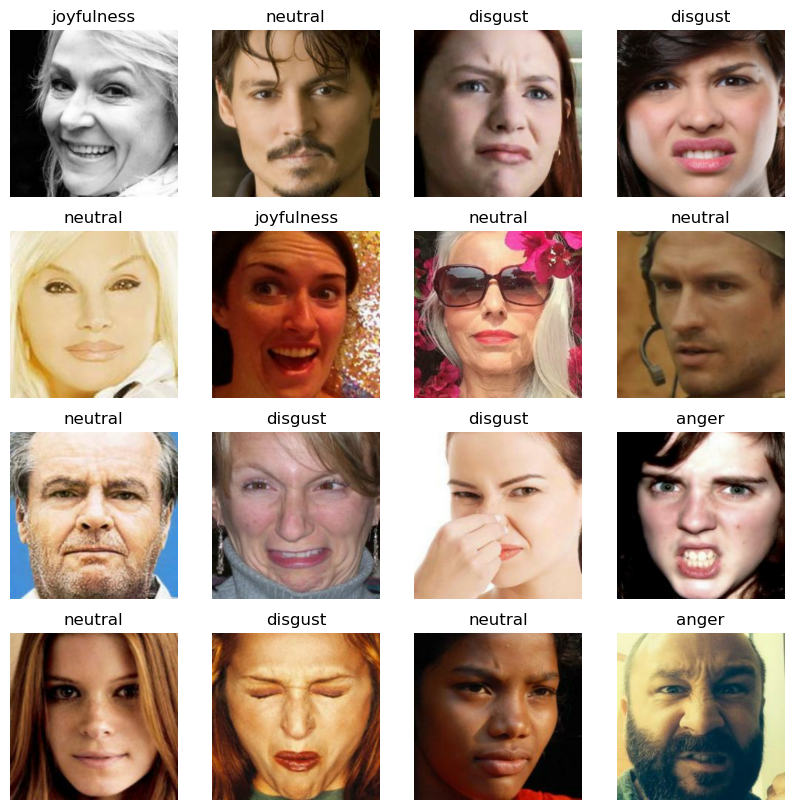

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_batches.take(10):
    for i in range(16):
        ax = plt.subplot(4, 4, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        category_class = int(tf.argmax(labels[i]))
        plt.title(class_names[category_class])
        plt.axis('off')

Также возьмем одно из изображений из получившегося датасета и посмотрим, получили ли мы желаемое разрешение. Это изображение пригодится нам в дальнейшм, поэтому сохраним его в переменную `one_pic`.

(299, 299, 3)


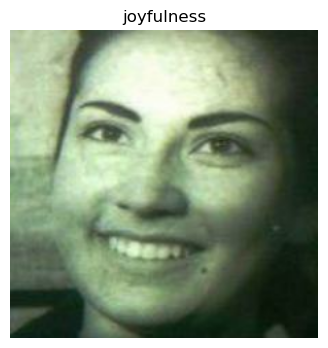

In [39]:
# одно случайное изображение
for images, labels in train_batches.take(30):
    one_pic = images[1].numpy()
    label = labels[1]
    break

print(one_pic.shape)
plt.figure(figsize=(4, 4))
plt.title(class_names[int(tf.argmax(label))])
plt.axis('off')
plt.imshow(one_pic.astype('uint8'));

Итак, датасет для модели создан, все фотографии приведены к единому разрешению, можно переходить к обработке данных для тренировки модели. Обработка данных для нашей модели состоит из двух частей: нормализация значений массива (`rescale`) и агументация данных. Подготовим обе части и запустим две модели - без аугментации и с ней, чтобы посмотреть, как этот блок слоев влияет на работу модели. 

### Слои для препроцессинга изображений

#### Rescale

Стандартизация значений матриц изображений - обязательная операция, если мы хотим получить хорошие результаты по работе нашей сети. Для использования данной предобученной модели значения матриц изображений необходимо отшкалировать по стандарту от -1 до 1 (именно такой стандарт использовался для обучения этой сети). Есть два способа создания соответствующего слоя:

```python
# для модели InceptionV3
preprocess_input = tf.keras.applications.inception_v3.preprocess_input

или

# для любой модели
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)
```

In [40]:
rescale = tf.keras.Sequential([
        tf.keras.layers.Rescaling(1./127.5, offset=-1,
                                  input_shape=IMAGE_SIZE + (3,),
                                  name='Rescaling')
])

Проверим качество работы слоя на фотографии, которую мы использовали выше.

Минимальное и максимальное значение пикселей: -0.9764706 1.0


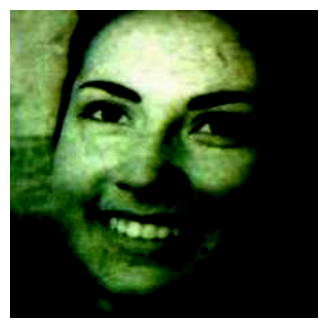

In [41]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

# увеличим размерность изображения до 4, так иначе оно не пройдет
# корректно через слой
result_for_rescale = rescale(np.expand_dims(one_pic, axis=0))
# print(result_for_rescale.shape)

# вернем результату размерность 3 для отображения
result = np.squeeze(result_for_rescale)
# print(result.shape)

plt.figure(figsize=(4, 4))
plt.axis('off')
plt.imshow(result)

# print("Picture's shape:", result.shape)
print("Минимальное и максимальное значение пикселей:", result.min(), result.max())

Слой отработал ожидаемым образом, при этом видно, что изменился контраст изображения. Это нормально, так как значения матрицы изображений были растянуты по обе стороны от 0. В любом случае, алгоритм обнаруживает зависимости не по внешнему виду картинок, как человеческий глаз, а исходя из числовых значений тензоров изображений.

#### Аугментация данных

Так как наш датасет создан из сравнительно небольшого набора данных, то для избежания переобучения мы воспользуемся всеми доступными возможностями библиотеки `keras`, в частности, добавим в модель слои агументации, которые искусственным образом увеличат количество изображений через внешнее изменение имеющихся. 

Создадим последовательность слоев `RandomFlip` (зеркальное отображение изображения в случайном порядке), `RandomRotation` (поворот изображения по часовой стрелке на случайный угол), `RandomZoom` (увеличение и уменьшение изображения в случайном порядке), а также `RandomContrast` (отключен). 

In [42]:
data_aug = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical', name='RandomFlip'),
    tf.keras.layers.RandomRotation(factor=1, fill_mode='reflect',
                                   name='RandomRotation'),
    tf.keras.layers.RandomZoom(height_factor=(-0.1, 0.3), name='RandomZoom'),
    # tf.keras.layers.RandomContrast(factor=(0.1, 0.1), name='RandomContrast')
])

Как и в случае с созданием датасета, проверим на уже использованном изображении из тренировочного датасета, как работает последовательность по аугментации данных. Если следующий блок с кодом запустить несколько раз, то мы увидим, как меняется изображение, проходя через вышеописанные слои.

> _**Note**: В версии tf 2.11.0 при выполнении нижеследующего кода выводятся предупреждения, которые не влияют на качество работы модели._

Минимальное и максимальное значение пикселей: -0.93750995 1.0


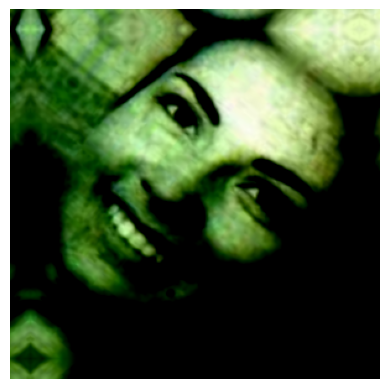

In [43]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

# увеличим размерность изображения до 4, так иначе оно не пройдет
# корректно через последовательность слоев
result_for_aug = np.expand_dims(result, axis=0)
augmented = data_aug(result_for_aug).numpy()
# print(augmented.shape)

plt.axis('off')

# вернем результату размерность 3 для отображения
plt.imshow(np.squeeze(augmented));

print("Минимальное и максимальное значение пикселей:", augmented.min(), augmented.max())

Итак, обе последовательности успешно справляются с поставленными перед ними задачами. Переходим к созданию и обучению моделей.

### Оптимизация работы кэша

Перед началом работы оптимизируем работу кэша следующим кодом:

In [44]:
train_batches = train_batches.cache().prefetch(buffer_size=1)
validation_batches = validation_batches.cache().prefetch(buffer_size=1)

## <b>Модель 2.2.1</b> | InceptionV3 

Authors: Christian Szegedy, Vincent Vanhoucke, Sergey Ioffe, Jonathon Shlens, Zbigniew Wojna

https://arxiv.org/abs/1512.00567

### Модуль `tf.keras.applications` | `feature_extractor_layer`

Создаем `feature_extractor` для обучения классификатора. 

In [45]:
do_fine_tuning = False
feature_extractor = tf.keras.applications.InceptionV3(
                                                include_top=False,
                                                weights="imagenet",
                                                input_shape=IMG_SHAPE
)
feature_extractor.trainable = do_fine_tuning

87910968/87910968 [==============================] - 3s 0us/step


### Архитектура модели

In [46]:
from tensorflow.keras import layers

REGULARIZER=tf.keras.regularizers.L1L2(l1=0.0, l2=0.5)

inputs = tf.keras.Input(shape=(IMG_SHAPE))
x = rescale(inputs)
x = data_aug(x)
x = feature_extractor(x, training=False)

x = layers.Flatten()(x)

x = layers.Dropout(DROPOUT_RATE)(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(num_classes, activation='softmax',
                       kernel_regularizer=REGULARIZER
                       )(x)
model = tf.keras.Model(inputs, outputs,
                       name='InceptionV3_based')

model.summary()

Model: "InceptionV3_based"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 299, 299, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dropout (Dropout)           (None, 131072)            0         
                                                                 
 batch_normalization_94 (Bat  (None, 131072)     

Посморим на количество переменных, которые будут обучаться в данной архитектуре.

In [47]:
len(model.trainable_variables)

4

### Компиляция

In [48]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=BASE_LR),
              loss='mse',
              metrics=metrics)

### Обучение модели

In [49]:
hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches,
                 callbacks=[early_stopping, lr_schedule])

Epoch 1/500
34/34 [==============================] - 26s 347ms/step - loss: 14.9156 - accuracy: 0.2111 - PR_AUC: 0.2057 - val_loss: 8.7523 - val_accuracy: 0.1509 - val_PR_AUC: 0.1801 - lr: 0.0100
Epoch 2/500
34/34 [==============================] - 7s 220ms/step - loss: 9.6311 - accuracy: 0.1991 - PR_AUC: 0.2024 - val_loss: 7.3368 - val_accuracy: 0.1950 - val_PR_AUC: 0.1974 - lr: 0.0100
Epoch 3/500
34/34 [==============================] - 7s 215ms/step - loss: 9.1896 - accuracy: 0.1741 - PR_AUC: 0.1908 - val_loss: 5.9951 - val_accuracy: 0.1698 - val_PR_AUC: 0.1978 - lr: 0.0100
Epoch 4/500
34/34 [==============================] - 7s 219ms/step - loss: 9.4130 - accuracy: 0.1861 - PR_AUC: 0.1936 - val_loss: 12.8861 - val_accuracy: 0.1761 - val_PR_AUC: 0.1897 - lr: 0.0100
Epoch 5/500
34/34 [==============================] - 7s 208ms/step - loss: 6.8855 - accuracy: 0.2176 - PR_AUC: 0.2084 - val_loss: 9.1384 - val_accuracy: 0.1572 - val_PR_AUC: 0.1840 - lr: 0.0085
Epoch 6/500
34/34 [========

### Визуализация данных по работе алгоритма

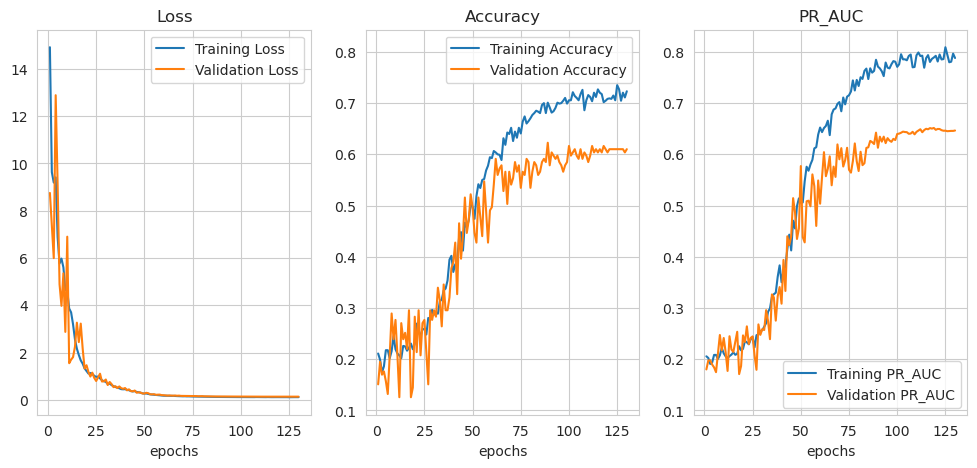

In [50]:
val_acc_viz(hist, len(hist.history['accuracy']))

### Предсказание модели

In [51]:
show_predictions(model, test_batches, visualization=False)

joyfulness is joyfulness (66.61%)
neutral is neutral (81.76%)
anger is neutral (44.32%)
neutral is neutral (39.82%)
neutral is neutral (49.58%)
fear is fear (47.31%)
neutral is neutral (73.20%)
anger is joyfulness (51.92%)
neutral is neutral (60.25%)
disgust is disgust (84.36%)


### Матрица ошибок

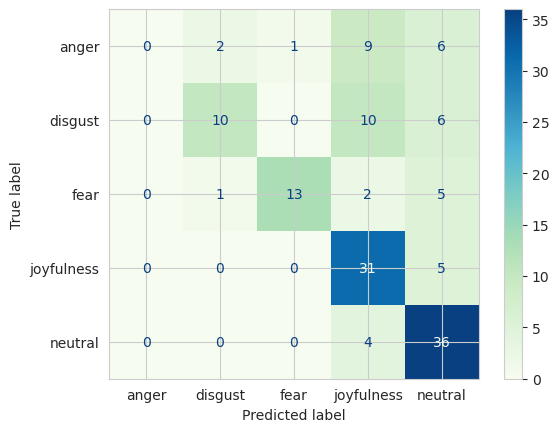

In [52]:
confusion_matrix(model, test_batches)

### Вывод

In [53]:
val_acc_best = np.max(hist.history['val_accuracy'])
val_auc_best = np.max(hist.history['val_PR_AUC'])
model_best_results = round(val_acc_best, 2), round(val_auc_best, 2)

print(f'val_accuracy: {model_best_results[0]}')
print(f'val_PR_AUC: {model_best_results[1]}')

val_accuracy: 0.62
val_PR_AUC: 0.65


In [54]:
# сохраним данные о модели
model_221 = model
hist_221 = hist
model_221_best_results = model_best_results

## Разморозка слоев

Второй этап - дообучение нашего классификатора.

In [55]:
do_fine_tuning = True
feature_extractor.trainable = do_fine_tuning

print(f'Разморозка слоев: {do_fine_tuning}.')

Разморозка слоев: True.


In [56]:
# с какого слоя мы размораживаем модель
fine_tune_at = int(len(feature_extractor.layers)/2)

# Заморозим все остальные слои
for layer in feature_extractor.layers[:fine_tune_at+1]:
    layer.trainable = False

Посмотрим на общее количество слоев в предобученной модели, а также на количество переменных, которые будут обучаться в размороженных слоях. 

In [57]:
print("Number of layers in the feature extractor: ", len(feature_extractor.layers))
print("Trainable variables in the feature extractor: ", len(feature_extractor.trainable_variables))

Number of layers in the feature extractor:  311
Trainable variables in the feature extractor:  92


При желании можно посмотреть на архитектуру `feature_extractor`.

In [58]:
# feature_extractor.summary()

### Компиляция

Теперь необходимо скомпилировать нашу уже обученную на предыдущем этапе модель, чтобы внесенные изменения были применены. Уменьшим базовый lr, чтобы избежать быстрого переобучения модели.

In [59]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=BASE_LR/100),
              loss='mse',
              metrics=metrics)

### Архитектура модели

In [60]:
model.summary()

Model: "InceptionV3_based"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 299, 299, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dropout (Dropout)           (None, 131072)            0         
                                                                 
 batch_normalization_94 (Bat  (None, 131072)     

In [61]:
len(model.trainable_variables)

96

### Обучение

In [62]:
hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches,
                 callbacks=[early_stopping, lr_schedule])

Epoch 1/500
34/34 [==============================] - 29s 334ms/step - loss: 0.1881 - accuracy: 0.5898 - PR_AUC: 0.6256 - val_loss: 0.2094 - val_accuracy: 0.5220 - val_PR_AUC: 0.6184 - lr: 1.0000e-04
Epoch 2/500
34/34 [==============================] - 9s 277ms/step - loss: 0.1543 - accuracy: 0.6843 - PR_AUC: 0.7524 - val_loss: 0.1815 - val_accuracy: 0.5597 - val_PR_AUC: 0.6869 - lr: 1.0000e-04
Epoch 3/500
34/34 [==============================] - 10s 287ms/step - loss: 0.1355 - accuracy: 0.7398 - PR_AUC: 0.8107 - val_loss: 0.1425 - val_accuracy: 0.7170 - val_PR_AUC: 0.7977 - lr: 1.0000e-04
Epoch 4/500
34/34 [==============================] - 9s 276ms/step - loss: 0.1225 - accuracy: 0.7611 - PR_AUC: 0.8385 - val_loss: 0.1231 - val_accuracy: 0.7358 - val_PR_AUC: 0.8380 - lr: 1.0000e-04
Epoch 5/500
34/34 [==============================] - 9s 271ms/step - loss: 0.1135 - accuracy: 0.7741 - PR_AUC: 0.8555 - val_loss: 0.1478 - val_accuracy: 0.6792 - val_PR_AUC: 0.7491 - lr: 1.0000e-04
Epoch 6/

### Визуализация данных по работе алгоритма

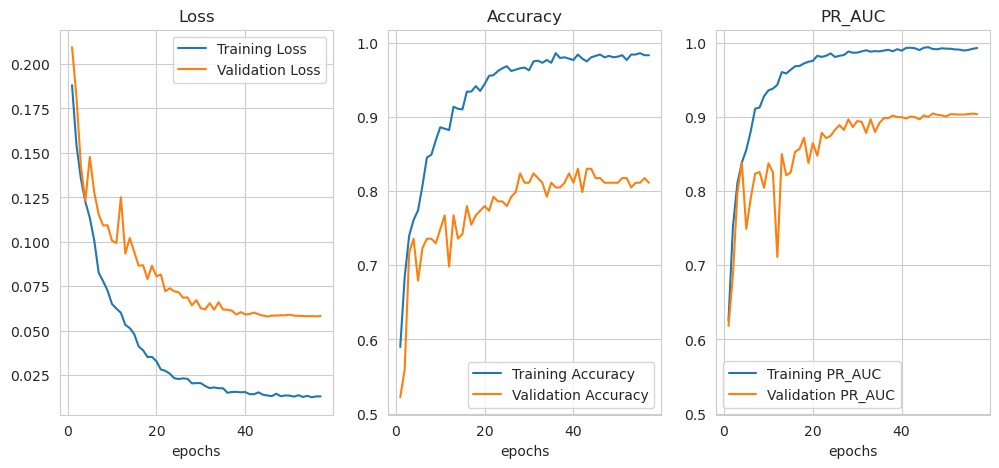

In [63]:
val_acc_viz(hist, len(hist.history['accuracy']))

### Предсказание модели

In [64]:
show_predictions(model, test_batches, visualization=False)

neutral is neutral (99.97%)
neutral is neutral (98.83%)
joyfulness is joyfulness (96.29%)
fear is fear (95.23%)
disgust is disgust (98.33%)
joyfulness is joyfulness (99.58%)
anger is anger (95.89%)
anger is neutral (73.04%)
neutral is anger (62.06%)
neutral is neutral (98.14%)


### Матрица ошибок

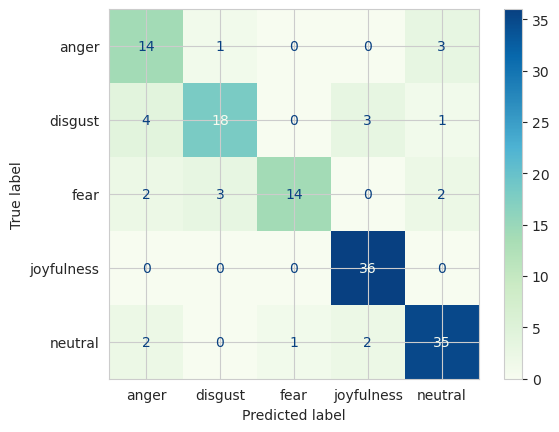

In [65]:
confusion_matrix(model, test_batches)

### Вывод

In [66]:
val_acc_best = np.max(hist.history['val_accuracy'])
val_auc_best = np.max(hist.history['val_PR_AUC'])
model_best_results = round(val_acc_best, 2), round(val_auc_best, 2)

print(f'val_accuracy: {model_best_results[0]}')
print(f'val_PR_AUC: {model_best_results[1]}')

val_accuracy: 0.83
val_PR_AUC: 0.9


Итак, данная модель достигла минимальной цели в 80% и значительно ее превзошла.

### Сохранение модели

Сохраним обученную модель на случай, если нам придется ее использовать в дальнейшем.

In [67]:
EMOTIONS_INCEPTIONV3_SAVED_MODEL = "./saved/inceptionv3_saved_model"
tf.saved_model.save(model, EMOTIONS_INCEPTIONV3_SAVED_MODEL)

Сохраним также названия классов.

In [68]:
with open('./saved/labels.txt', 'w', encoding="utf-8") as f:
    f.write('\n'.join(class_names))

## <b>Модель 2.2.2</b> | MobileNetV2

Authors: Mark Sandler, Andrew Howard, Menglong Zhu, Andrey Zhmoginov, Liang-Chieh Chen

https://arxiv.org/abs/1801.04381

### Новый `tf.dataset`

Для следующей модели нам потребуется заново создать `tf.dataset` под то разрешение изображений, которое используется в MobileNetV2 - (224, 224). 

In [69]:
train_batches, validation_batches, test_batches = datasets_prep(image_size=(224, 224))

Found 1080 files belonging to 5 classes.
Found 159 files belonging to 5 classes.
Found 141 files belonging to 5 classes.


### Модуль `tf.keras.applications` | `feature_extractor_layer`

Теперь повторим все шаги, которые мы проделывали для предыдущей модели.

In [70]:
do_fine_tuning = False
feature_extractor = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
feature_extractor.trainable = do_fine_tuning

9406464/9406464 [==============================] - 0s 0us/step


### Архитектура модели

In [71]:
from tensorflow.keras import layers

strides = 2
REGULARIZER=tf.keras.regularizers.L1L2(l1=0.0, l2=0.5)

inputs = tf.keras.Input(shape=(IMG_SHAPE))
x = rescale(inputs)
x = data_aug(x)
x = feature_extractor(x, training=False)

x = layers.Flatten()(x)

x = layers.Dropout(DROPOUT_RATE)(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(num_classes, activation='softmax',
                       kernel_regularizer=REGULARIZER
                       )(x)
model = tf.keras.Model(inputs, outputs,
                       name='MobileNetV2_RMSprop_mse')

model.summary()

Model: "MobileNetV2_RMSprop_mse"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 299, 299, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 10, 10, 1280)     2257984   
 ional)                                                          
                                                                 
 flatten_1 (Flatten)         (None, 128000)            0         
                                                                 
 dropout_1 (Dropout)         (None, 128000)            0         
                                           

In [72]:
len(model.trainable_variables)

4

### Компиляция

In [73]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=BASE_LR),
              loss='mse',
              metrics=metrics)

### Обучение модели

In [74]:
hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches,
                 callbacks=[early_stopping, lr_schedule])

Epoch 1/500
34/34 [==============================] - 16s 279ms/step - loss: 14.6224 - accuracy: 0.1963 - PR_AUC: 0.2291 - val_loss: 14.3040 - val_accuracy: 0.1887 - val_PR_AUC: 0.1891 - lr: 0.0100
Epoch 2/500
34/34 [==============================] - 8s 235ms/step - loss: 9.2835 - accuracy: 0.2111 - PR_AUC: 0.2066 - val_loss: 13.0247 - val_accuracy: 0.2767 - val_PR_AUC: 0.2329 - lr: 0.0100
Epoch 3/500
34/34 [==============================] - 9s 245ms/step - loss: 9.9459 - accuracy: 0.2463 - PR_AUC: 0.2239 - val_loss: 13.1503 - val_accuracy: 0.1824 - val_PR_AUC: 0.1882 - lr: 0.0100
Epoch 4/500
34/34 [==============================] - 8s 227ms/step - loss: 7.3771 - accuracy: 0.2176 - PR_AUC: 0.2116 - val_loss: 5.1045 - val_accuracy: 0.2642 - val_PR_AUC: 0.2323 - lr: 0.0085
Epoch 5/500
34/34 [==============================] - 8s 225ms/step - loss: 7.5584 - accuracy: 0.2037 - PR_AUC: 0.2031 - val_loss: 8.2595 - val_accuracy: 0.2201 - val_PR_AUC: 0.2061 - lr: 0.0085
Epoch 6/500
34/34 [======

### Визуализация данных по работе алгоритма

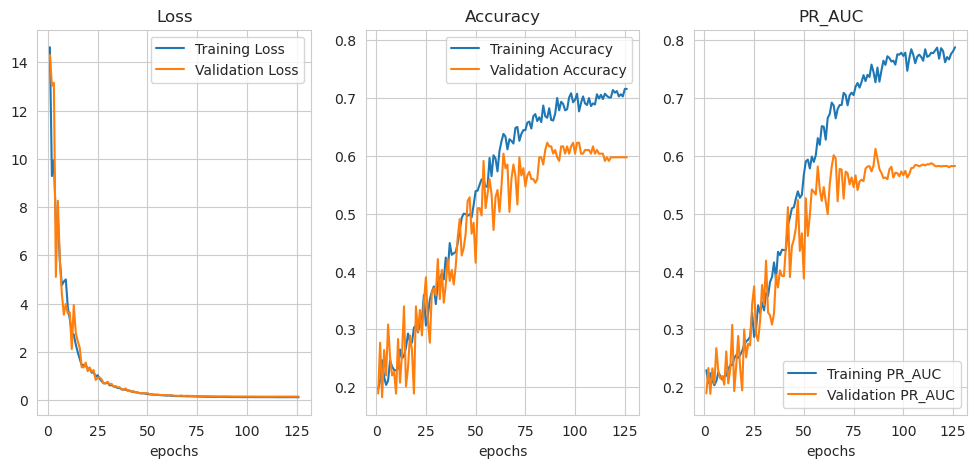

In [75]:
val_acc_viz(hist, len(hist.history['accuracy']))

### Предсказание модели

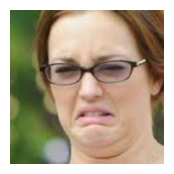

disgust is neutral (30.85%)


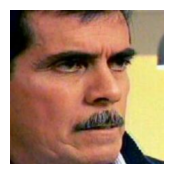

anger is neutral (57.72%)


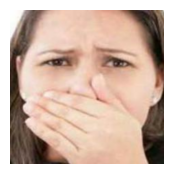

disgust is disgust (60.68%)


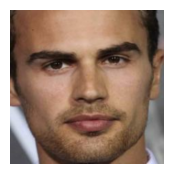

neutral is neutral (82.10%)


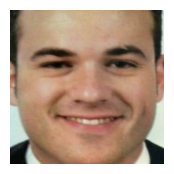

joyfulness is neutral (52.38%)


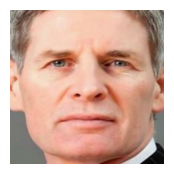

neutral is neutral (70.09%)


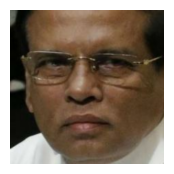

neutral is neutral (72.23%)


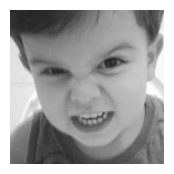

anger is joyfulness (50.97%)


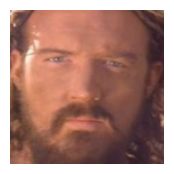

neutral is neutral (60.32%)


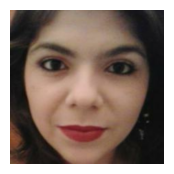

neutral is neutral (66.22%)


In [76]:
show_predictions(model, test_batches, visualization=True)

### Матрица ошибок

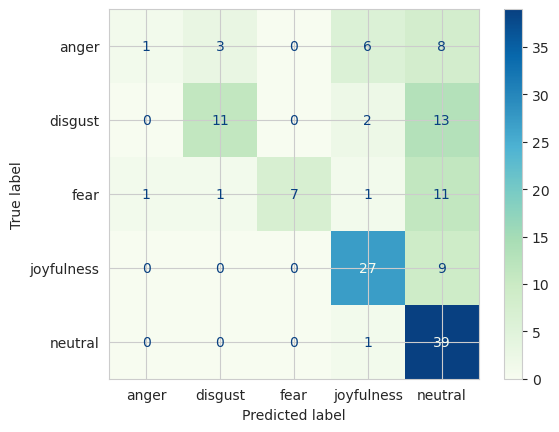

In [77]:
confusion_matrix(model, test_batches)

### Вывод

In [78]:
val_acc_best = np.max(hist.history['val_accuracy'])
val_auc_best = np.max(hist.history['val_PR_AUC'])
model_best_results = round(val_acc_best, 2), round(val_auc_best, 2)

print(f'val_accuracy: {model_best_results[0]}')
print(f'val_PR_AUC: {model_best_results[1]}')

val_accuracy: 0.62
val_PR_AUC: 0.61


In [79]:
# сохраним данные о модели
model_222 = model
hist_222 = hist
model_222_best_results = model_best_results

## Разморозка слоев

In [80]:
do_fine_tuning = True
feature_extractor.trainable = do_fine_tuning

print(f'Разморозка слоев: {do_fine_tuning}.')

Разморозка слоев: True.


На этот раз разморозим все слои.

In [81]:
# с какого слоя мы размораживаем модель
fine_tune_at = 0

# Заморозим все остальные слои
for layer in feature_extractor.layers[:fine_tune_at+1]:
    layer.trainable = False

Посмотрим на общее количество слоев в предобученной модели, а также на количество переменных, которые будут обучаться в размороженных слоях. 

In [82]:
print("Number of layers in the feature extractor: ", len(feature_extractor.layers))
print("Trainable variables in the feature extractor: ", len(feature_extractor.trainable_variables))

Number of layers in the feature extractor:  154
Trainable variables in the feature extractor:  156


При желании можно посмотреть на архитектуру `feature_extractor`.

In [83]:
# feature_extractor.summary()

### Компиляция

Теперь необходимо скомпилировать нашу уже обученную на предыдущем этапе модель, чтобы изменения были применены. Уменьшим базовый lr, чтобы избежать переобучения нашй уже обученной модели.

In [84]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=BASE_LR/100),
              loss='mse',
              metrics=metrics)

### Архитектура модели

In [85]:
model.summary()

Model: "MobileNetV2_RMSprop_mse"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 299, 299, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 10, 10, 1280)     2257984   
 ional)                                                          
                                                                 
 flatten_1 (Flatten)         (None, 128000)            0         
                                                                 
 dropout_1 (Dropout)         (None, 128000)            0         
                                           

In [86]:
len(model.trainable_variables)

160

### Обучение

In [87]:
hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches,
                 callbacks=[early_stopping, lr_schedule])

Epoch 1/500
34/34 [==============================] - 37s 395ms/step - loss: 0.1916 - accuracy: 0.4907 - PR_AUC: 0.5181 - val_loss: 0.2034 - val_accuracy: 0.4906 - val_PR_AUC: 0.4863 - lr: 1.0000e-04
Epoch 2/500
34/34 [==============================] - 12s 344ms/step - loss: 0.1662 - accuracy: 0.5787 - PR_AUC: 0.6067 - val_loss: 0.1762 - val_accuracy: 0.5472 - val_PR_AUC: 0.5322 - lr: 1.0000e-04
Epoch 3/500
34/34 [==============================] - 12s 345ms/step - loss: 0.1559 - accuracy: 0.5926 - PR_AUC: 0.6510 - val_loss: 0.1633 - val_accuracy: 0.6101 - val_PR_AUC: 0.6457 - lr: 1.0000e-04
Epoch 4/500
34/34 [==============================] - 13s 362ms/step - loss: 0.1516 - accuracy: 0.6157 - PR_AUC: 0.6689 - val_loss: 0.1814 - val_accuracy: 0.5220 - val_PR_AUC: 0.5702 - lr: 1.0000e-04
Epoch 5/500
34/34 [==============================] - 12s 342ms/step - loss: 0.1445 - accuracy: 0.6250 - PR_AUC: 0.6827 - val_loss: 0.1991 - val_accuracy: 0.4277 - val_PR_AUC: 0.4977 - lr: 8.5000e-05
Epoch

### Визуализация данных по работе алгоритма

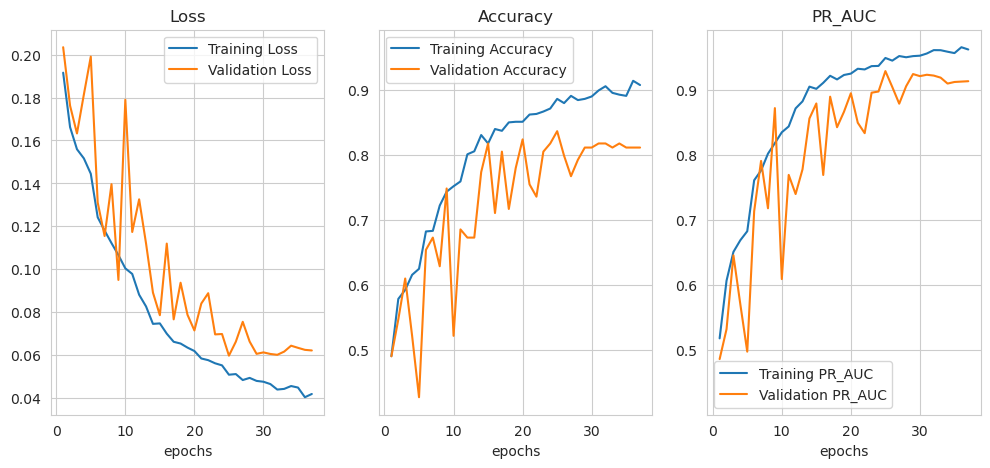

In [88]:
val_acc_viz(hist, len(hist.history['accuracy']))

### Предсказание модели

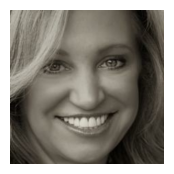

joyfulness is joyfulness (99.48%)


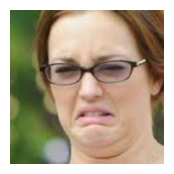

disgust is disgust (98.86%)


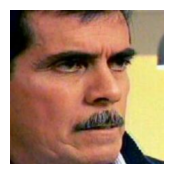

anger is neutral (85.34%)


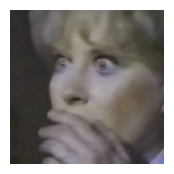

fear is anger (45.89%)


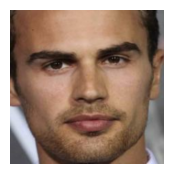

neutral is neutral (99.67%)


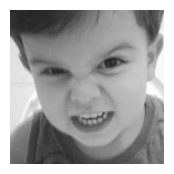

anger is joyfulness (69.54%)


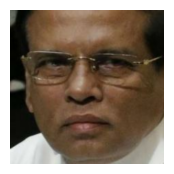

neutral is neutral (88.59%)


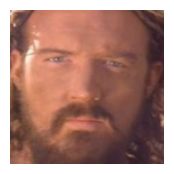

neutral is neutral (79.75%)


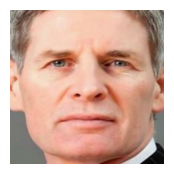

neutral is neutral (92.22%)


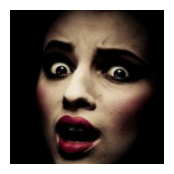

fear is anger (55.22%)


In [89]:
show_predictions(model, test_batches, visualization=True)

### Матрица ошибок

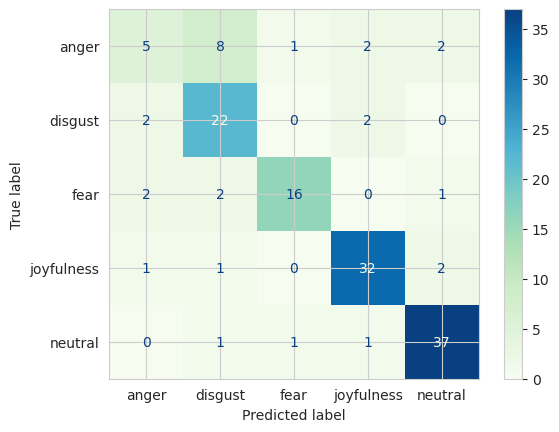

In [90]:
confusion_matrix(model, test_batches)

### Вывод

In [91]:
val_acc_best = np.max(hist.history['val_accuracy'])
val_auc_best = np.max(hist.history['val_PR_AUC'])
model_best_results = round(val_acc_best, 2), round(val_auc_best, 2)

print(f'val_accuracy: {model_best_results[0]}')
print(f'val_PR_AUC: {model_best_results[1]}')

val_accuracy: 0.84
val_PR_AUC: 0.93


Данная модель также превзошла цель в 80%. Как видно из предсказаний на конкретных изображениях, модель путается с гневом и страхом, именно эти изображения представлены в количестве менее 200 штук. Таким образом, для дальнейшего улучшения качества модели следует, в первую очередь, обратить внимание на улучшение самого датасета: увеличить общее количество изображений и желательно сбалансировать классы.  

### Сохранение модели

Сохраним обученную модель на случай, если нам придется ее использовать в дальнейшем.

In [92]:
EMOTIONS_MOBILENETV2_SAVED_MODEL = "./saved/momobilenetv2_saved_model"
tf.saved_model.save(model, EMOTIONS_MOBILENETV2_SAVED_MODEL)

# <b>2.3. Scikit-learn</b>

# <b>Использованные источники и литература</b>

**Курсы**

1. Holbrook R. Intro to Deep Learning // https://www.kaggle.com/learn/intro-to-deep-learning
1. Moroney L. Device-based Models with TensorFlow Lite // https://www.coursera.org/learn/device-based-models-tensorflow
1. Tensorflow Guide. TensorFlow Basics // https://www.tensorflow.org/guide

**Статьи**
1. Data augmentation // https://www.tensorflow.org/tutorials/images/data_augmentation
1. Image classification // https://www.tensorflow.org/tutorials/images/classification
1. Lakhani N.D. Statistical Evaluation Metrics // https://iust-projects.ir/post/minidm01/
1. Load and preprocess images // https://www.tensorflow.org/tutorials/load_data/images
1. Preprocessing layers // https://keras.io/api/layers/preprocessing_layers/
1. Transfer learning and fine-tuning // https://www.tensorflow.org/tutorials/images/transfer_learning
1. Transfer learning and fine-tuning // https://keras.io/guides/transfer_learning/
1. Working with preprocessing layers // https://www.tensorflow.org/guide/keras/preprocessing_layers

**Модели**
1. InceptionV3 // https://keras.io/api/applications/inceptionv3/
1. MobileNet // https://keras.io/api/applications/mobilenet/

**Форумы**
1. StackOverflow // https://stackoverflow.com/
1. GitHub // https://github.com/